In [51]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
pd.set_option('display.float_format', '{:.2f}'.format)

In [52]:
df = pd.read_csv('history.csv', index_col=0)
limits = pd.read_excel('limits.xlsx')

In [53]:
optimized_features = ['T1_s3', 'T2_s3', 'T3_s3', 'T4_s3', 'T7_s3', 'T10_s2', 'Q4_s2']

## are there any emergency periods?

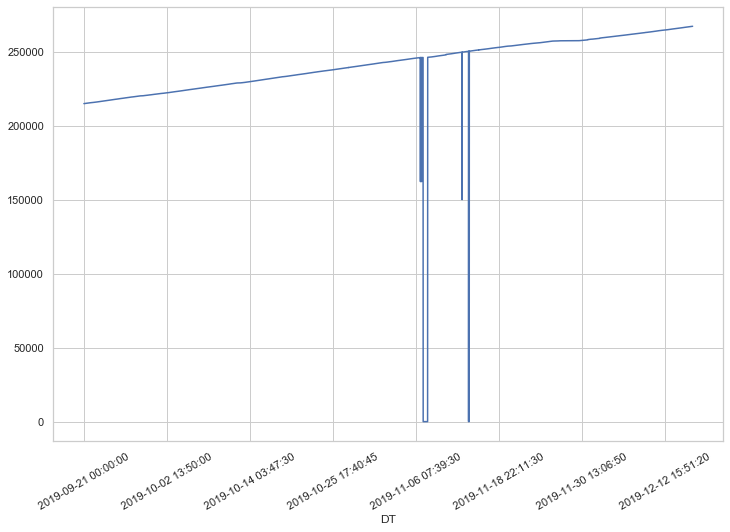

In [54]:
df['pR1d2_s1'].plot(grid=True, figsize=(12,8))
plt.xticks(rotation=30);

In [5]:
df = df.loc[df['pR1d2_s1'] > 200000]

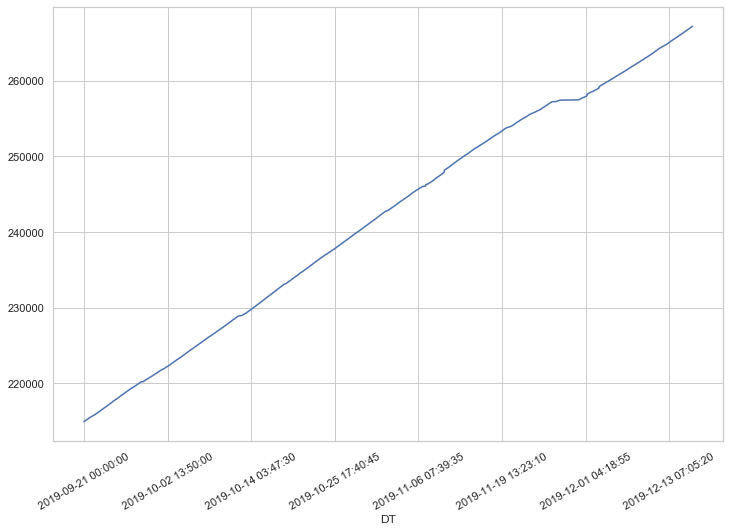

In [6]:
df['pR1d2_s1'].plot(grid=True, figsize=(12,8))
plt.xticks(rotation=30);

## understanding data

In [7]:
df.head()

,D1_s3,D2_OBPR_s5,EU8_s2,Ef1_s3,Ei10_s3,Ei11_s3,Ei12_s3,Ei13_s3,Ei14_s3,Ei15_s3,...,T4_s3,T5_s3,T6_s3,T7_s3,T9_s2,T9_s3,W1_s1,W1_s3,pQ1d2_s1,pR1d2_s1
DT,,,,,,,,,,,,,,,,,,,,,
2019-09-21 00:00:00,1.00,1.05,-5.00,16.50,15.73,16.63,13.80,11.29,21.35,0.09,...,72.20,55.24,32.20,61.30,70.38,-5.00,288.10,153.44,23.66,214914.59
2019-09-21 00:00:05,1.00,1.05,-5.00,16.54,15.37,16.41,13.68,11.14,20.78,0.10,...,72.20,55.14,32.20,61.30,70.28,-5.00,287.86,150.84,23.66,214914.59
2019-09-21 00:00:10,1.00,1.05,-5.00,16.69,15.40,16.35,13.61,11.10,20.74,0.16,...,72.20,55.14,32.20,61.24,70.19,-5.00,288.89,151.58,23.66,214914.59
2019-09-21 00:00:15,1.00,1.05,-5.00,16.66,15.44,16.28,13.51,11.17,20.81,0.10,...,72.20,55.05,32.20,61.24,70.12,-5.00,287.77,148.60,24.22,214914.59
2019-09-21 00:00:20,1.00,1.05,-5.00,16.66,15.40,16.54,13.55,11.17,21.10,0.13,...,72.20,55.05,32.20,61.20,69.99,-5.00,290.53,146.36,24.22,214914.59


In [8]:
df.shape

(1455819, 69)

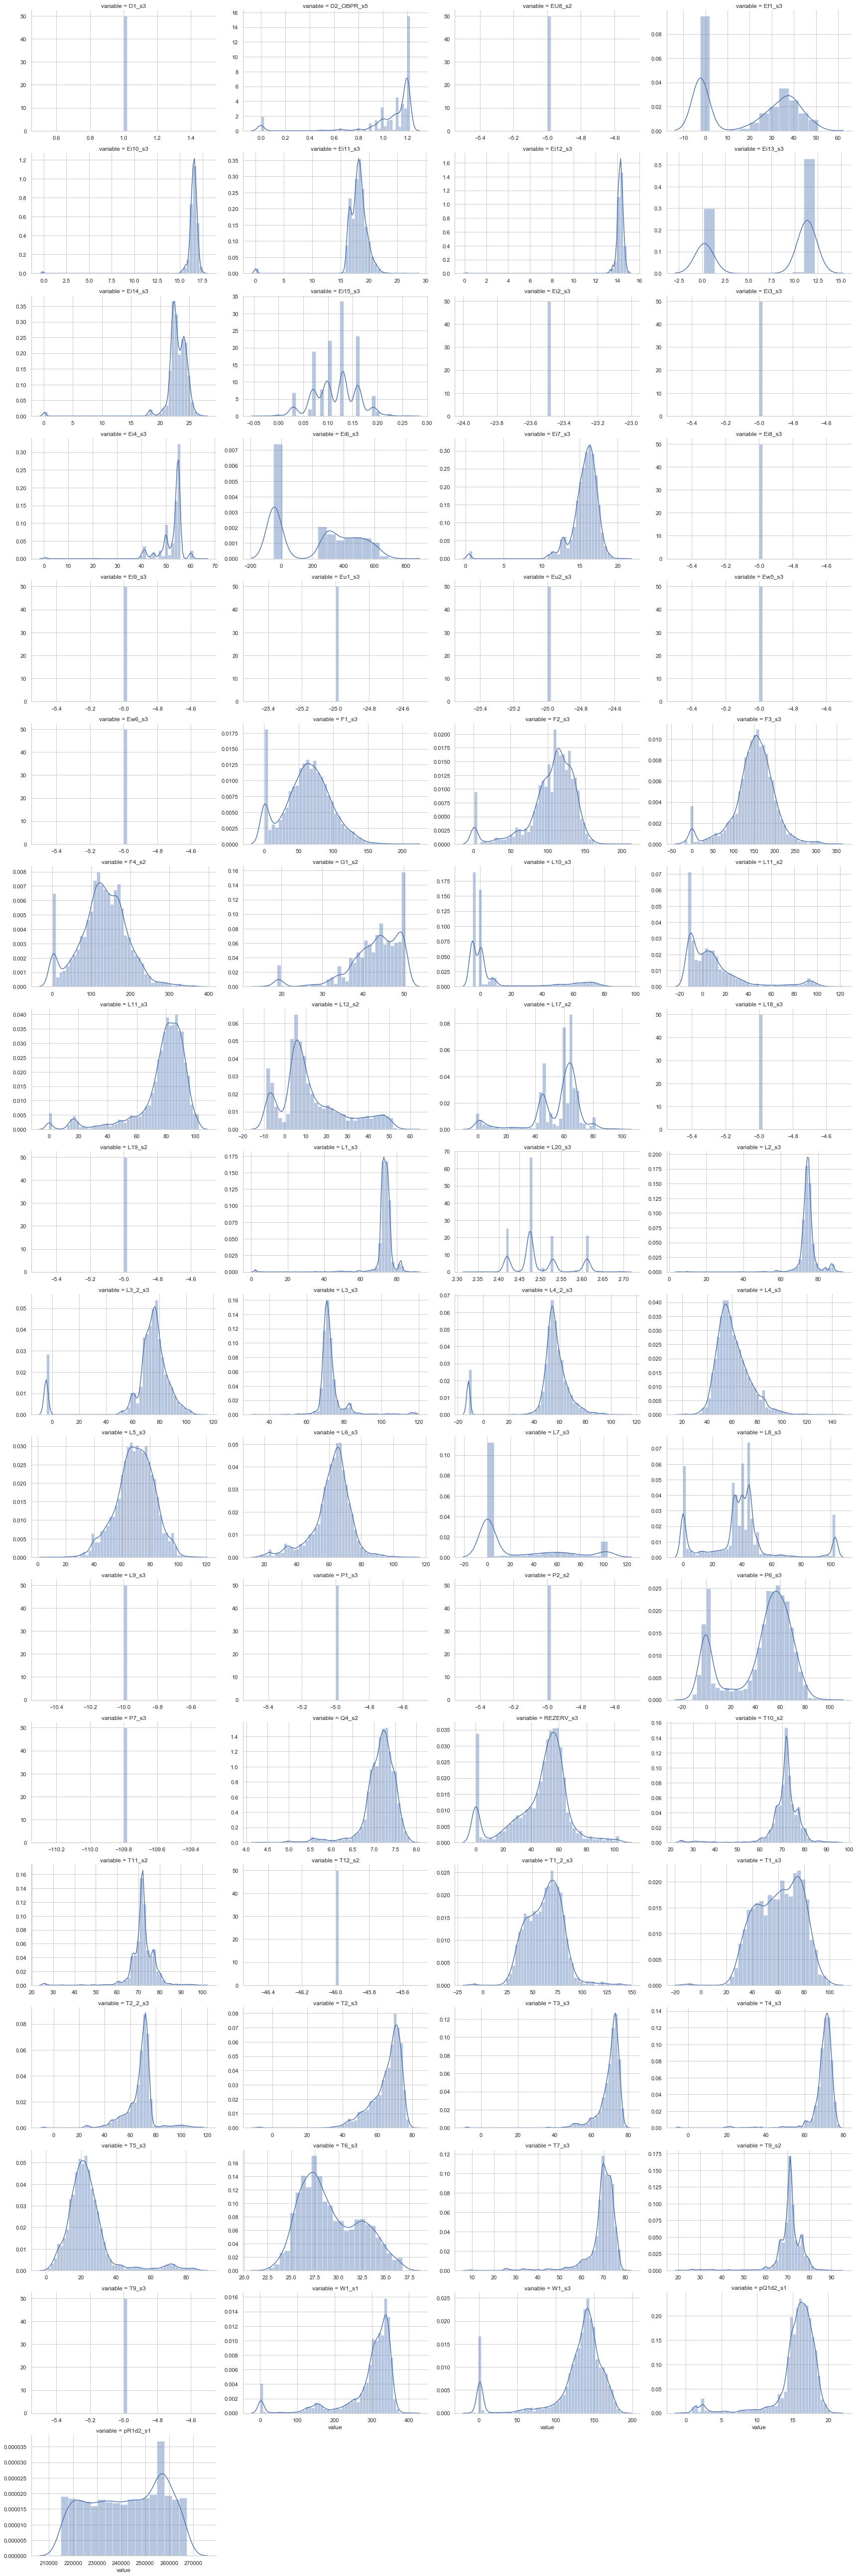

In [9]:
grid = sns.FacetGrid(pd.melt(df.sample(5000)), col="variable", sharex=False, sharey=False, col_wrap=4, height=4, aspect=1.5)
grid.map(sns.distplot, "value")

## removing faulty sensors

In [10]:
df = df.loc[:, df.mean() > 0]
df = df.loc[:, df.std() > 0]

## removing correlated features

In [11]:
df_corr = df.corr()
df_corr = df_corr.mask(np.triu(np.ones_like(df_corr, dtype=np.bool)))

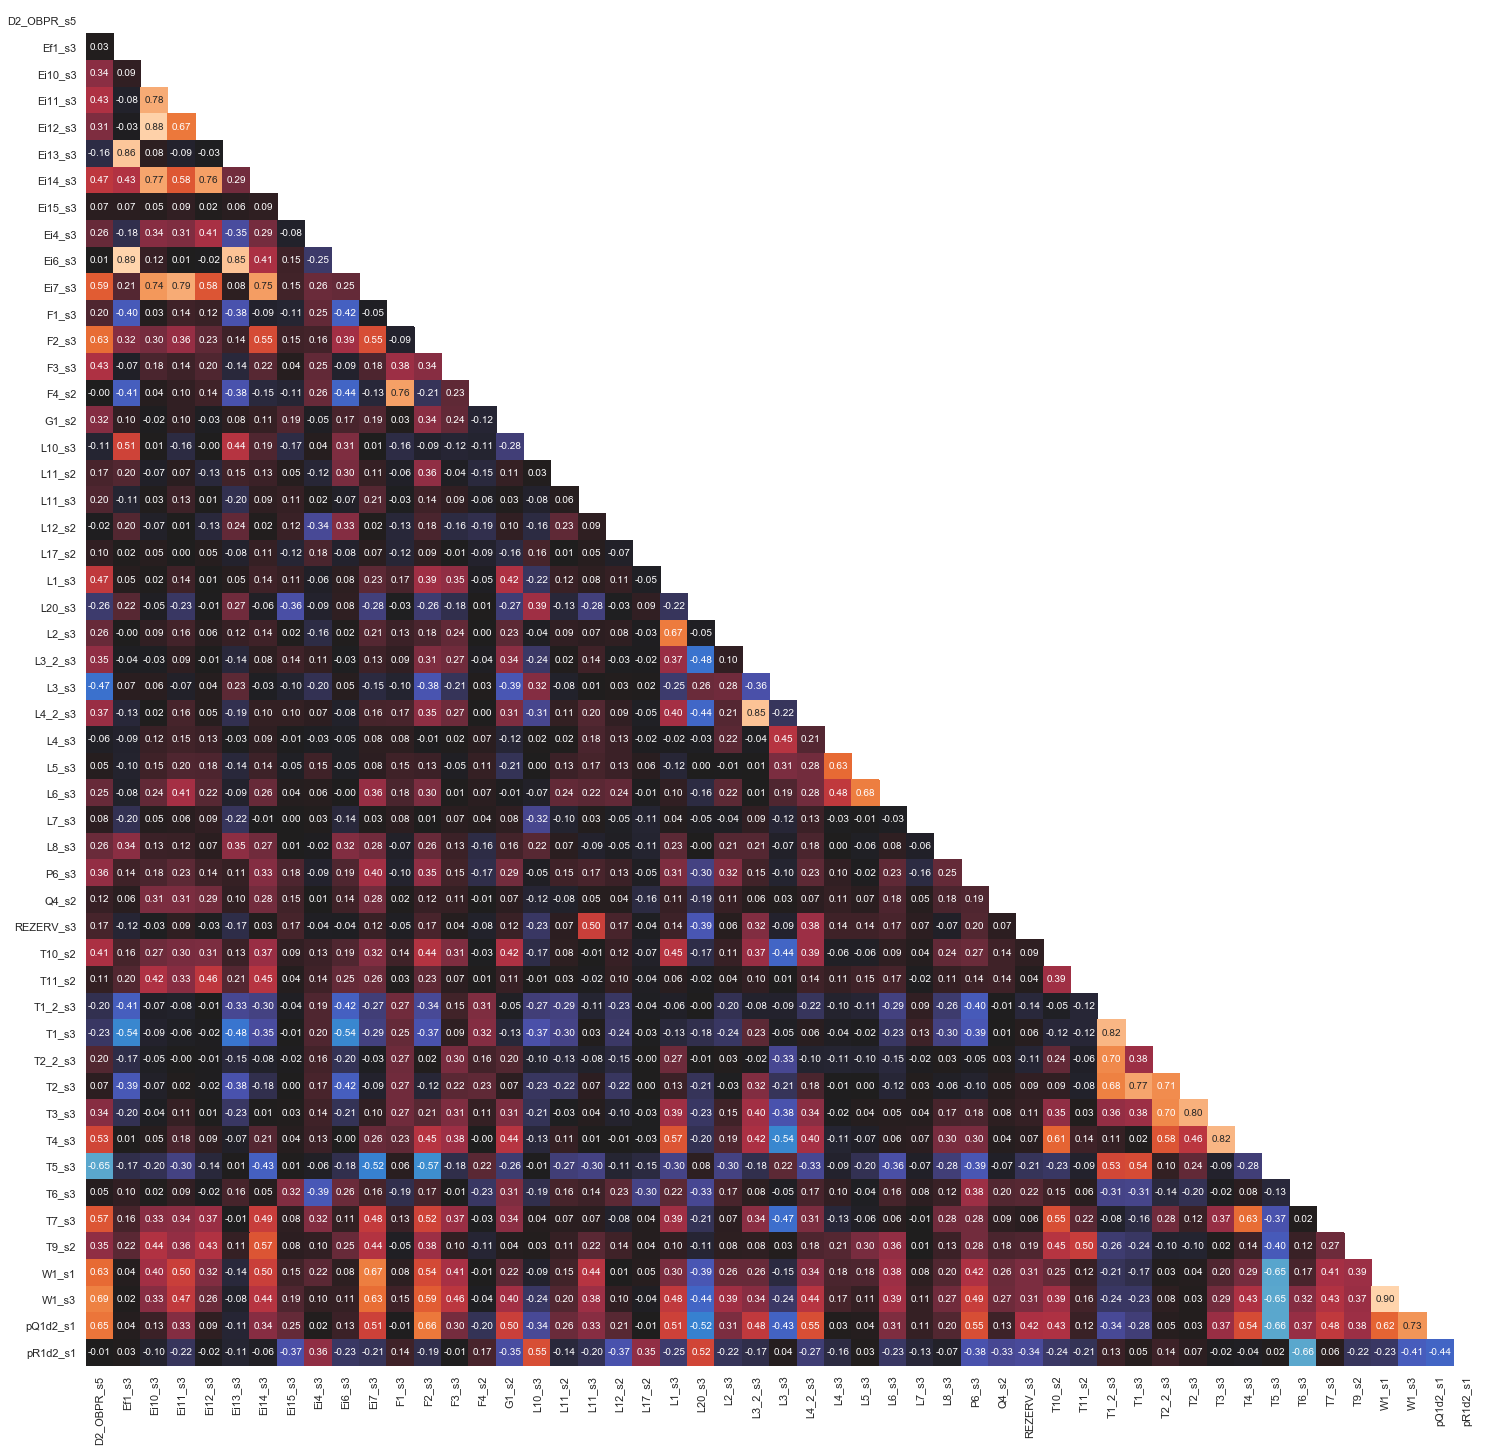

In [12]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_corr, fmt='.2f', annot=True, center=0, cbar=False)

In [13]:
df_corr_high = df_corr[abs(df_corr) > 0.7].dropna(how='all').dropna(axis=1, how='all')

In [14]:
df_corr_high

,Ef1_s3,Ei10_s3,Ei11_s3,Ei12_s3,Ei13_s3,Ei14_s3,F1_s3,L3_2_s3,T1_2_s3,T1_s3,T2_2_s3,T2_s3,T3_s3,W1_s1,W1_s3
Ei11_s3,nan,0.78,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ei12_s3,nan,0.88,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ei13_s3,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ei14_s3,nan,0.77,nan,0.76,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ei6_s3,0.89,nan,nan,nan,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ei7_s3,nan,0.74,0.79,nan,nan,0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan
F4_s2,nan,nan,nan,nan,nan,nan,0.76,nan,nan,nan,nan,nan,nan,nan,nan
L4_2_s3,nan,nan,nan,nan,nan,nan,nan,0.85,nan,nan,nan,nan,nan,nan,nan
T1_s3,nan,nan,nan,nan,nan,nan,nan,nan,0.82,nan,nan,nan,nan,nan,nan
T2_s3,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.77,0.71,nan,nan,nan,nan


In [15]:
delete_features = []
for feature in df_corr_high.columns:
    if (feature not in optimized_features) and (feature != 'W1_s3'):
        delete_features.append(feature)
        
df.drop(columns=delete_features, inplace=True)

In [16]:
delete_features

['Ef1_s3',
 'Ei10_s3',
 'Ei11_s3',
 'Ei12_s3',
 'Ei13_s3',
 'Ei14_s3',
 'F1_s3',
 'L3_2_s3',
 'T1_2_s3',
 'T2_2_s3',
 'W1_s1']

## aggregate data

In [17]:
df.index = pd.to_datetime(df.index)

In [ ]:
df['pR1d2_s1'].

In [18]:
df_aggregated = pd.DataFrame()

for i in range(0, 30, 10):
    df_shift = df.copy()
    df_shift.index = df_shift.index + pd.DateOffset(minutes=i)
    
    df_aggregate_to_mean = df_shift.drop(columns=['pR1d2_s1'])
    df_aggregate_to_sum = df_shift[['pR1d2_s1']]

    df_aggregate_to_mean = df_aggregate_to_mean.resample('30Min').mean()

    df_aggregate_to_sum = df_aggregate_to_sum.diff()
    df_aggregate_to_sum = df_aggregate_to_sum.resample('30Min').sum()

    df_shift = pd.merge(df_aggregate_to_mean, df_aggregate_to_sum, left_index=True, right_index=True)
    df_shift.drop(df_shift.tail(1).index, inplace=True)
    df_shift.drop(df_shift.head(1).index, inplace=True)
    df_shift.dropna(inplace=True)
    
    df_shift.index = df_shift.index - pd.DateOffset(minutes=i)
    
    df_aggregated = pd.concat([df_aggregated, df_shift])
    
df = df_aggregated.copy()
df = df.sort_values(by='DT')

In [19]:
df.shape

(12163, 40)

## understanding aggregated data

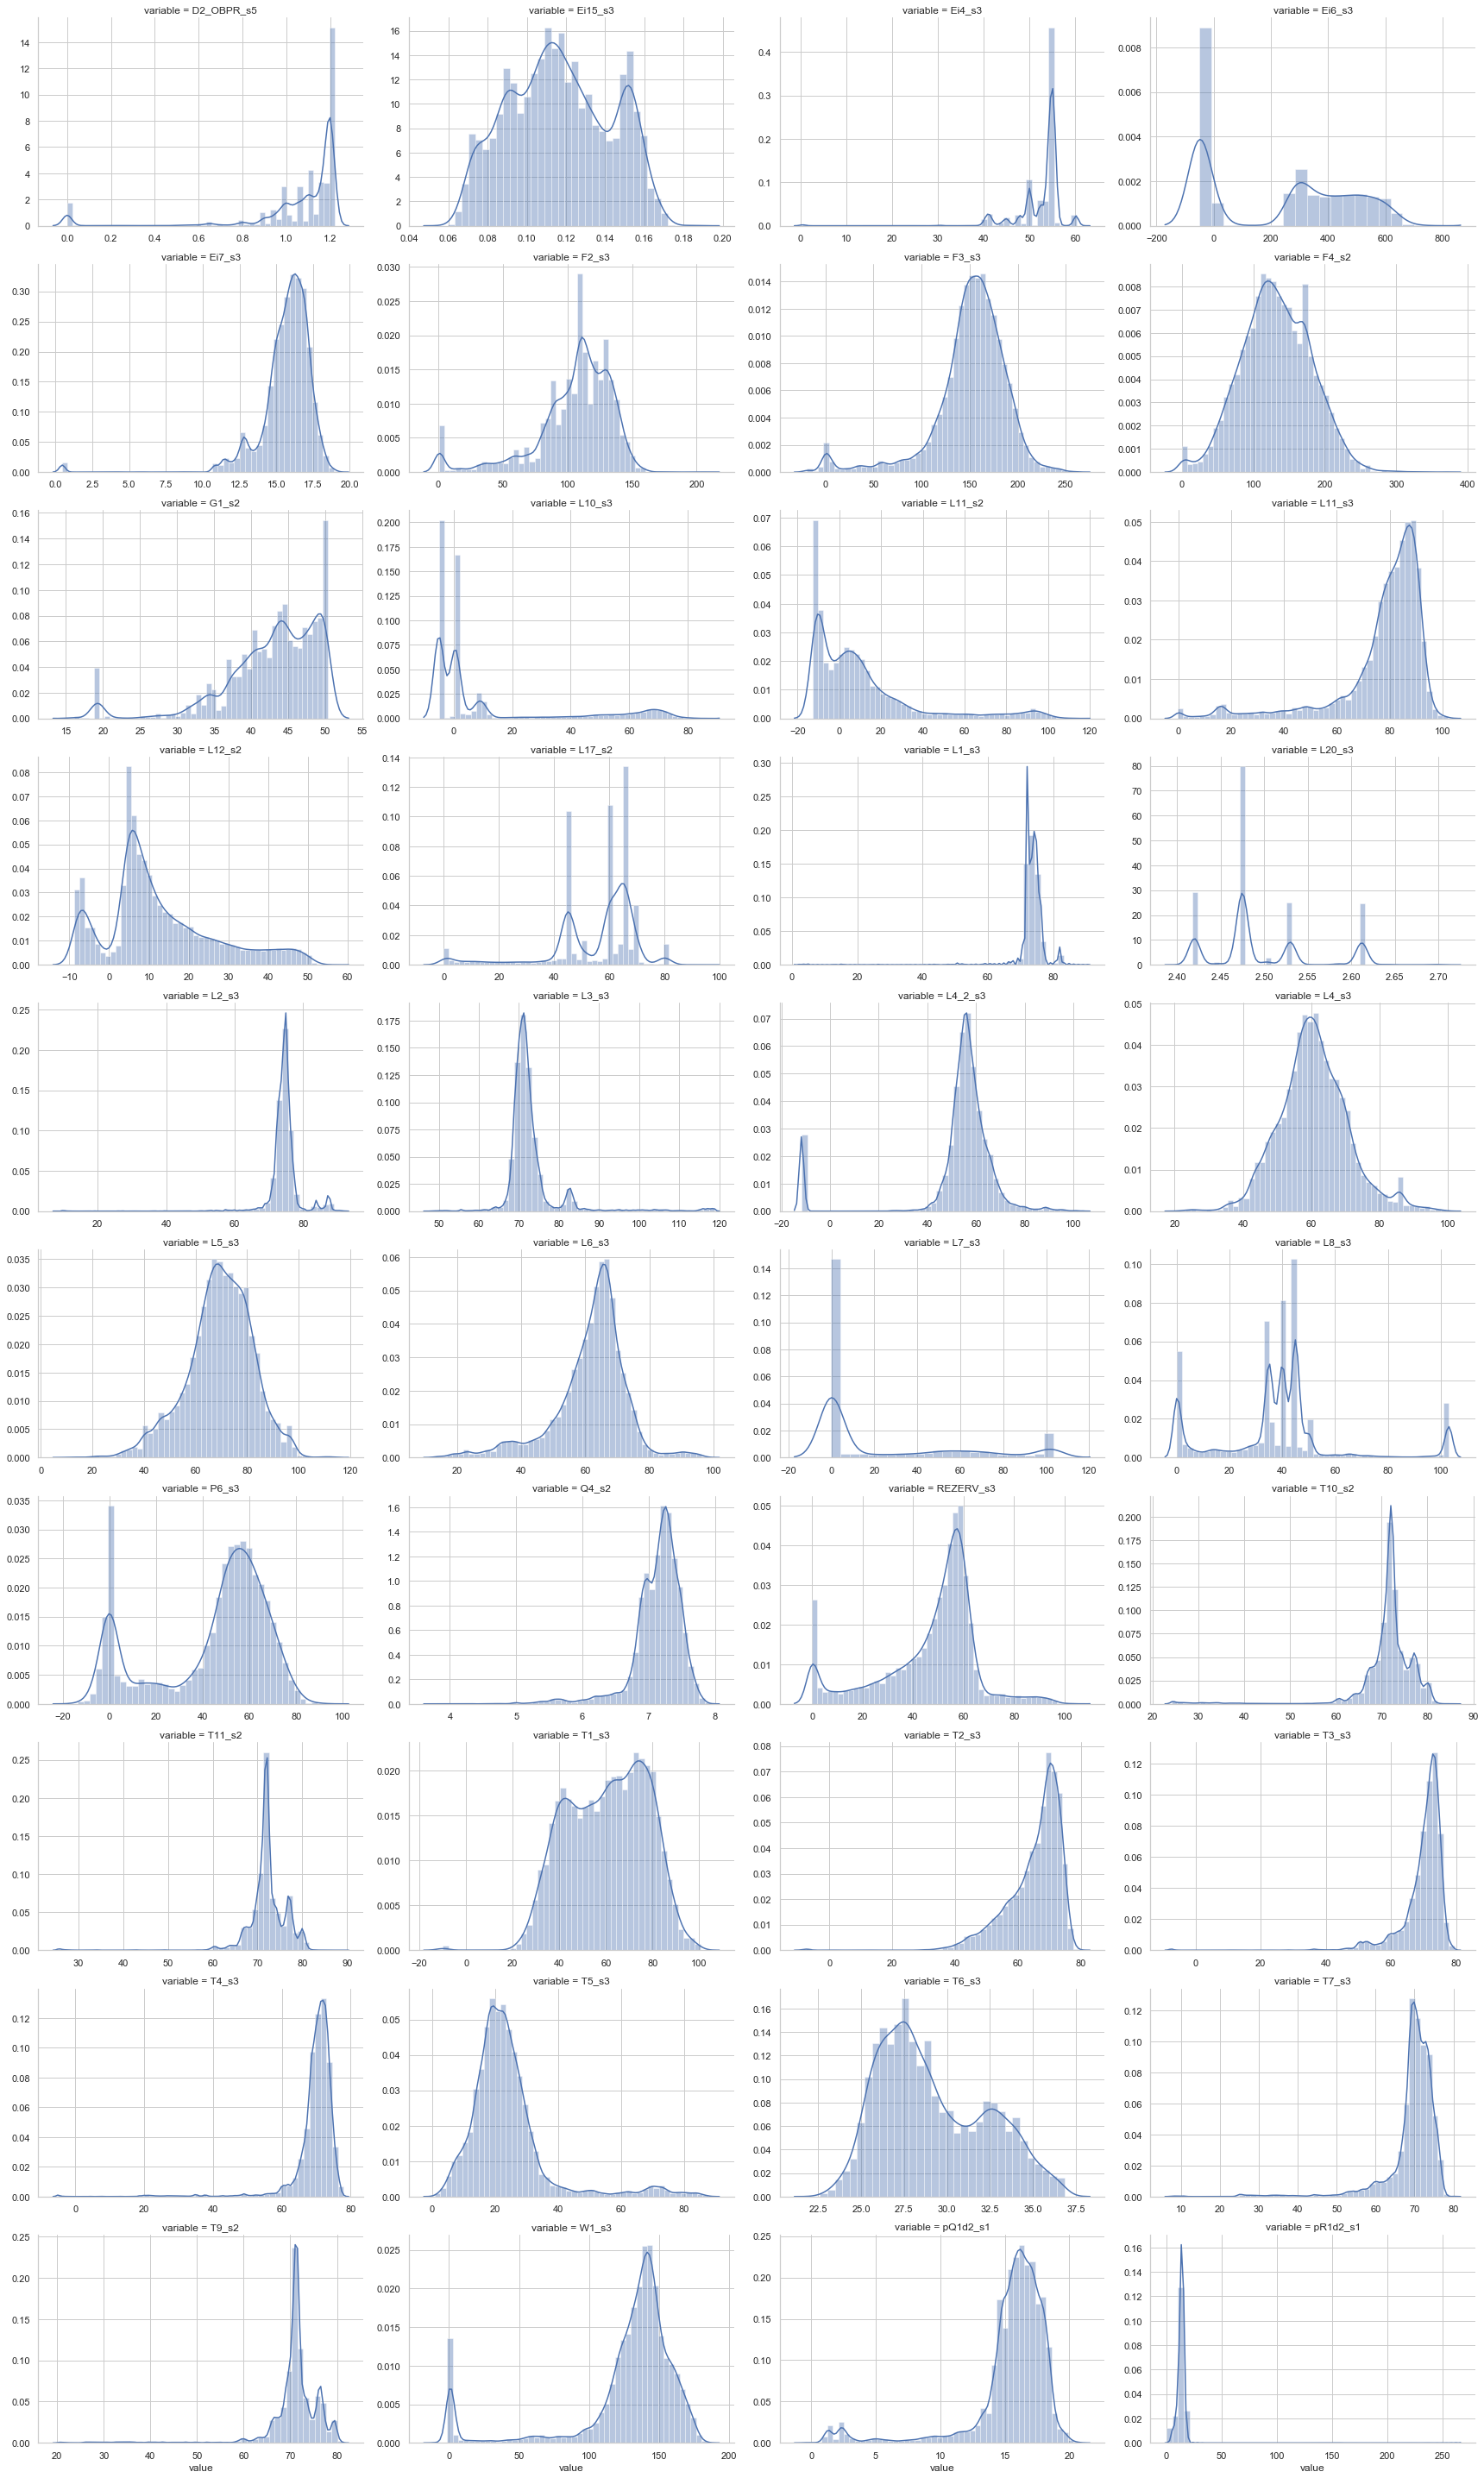

In [20]:
grid = sns.FacetGrid(pd.melt(df), col="variable", sharex=False, sharey=False, col_wrap=4, height=4, aspect=1.5)
grid.map(sns.distplot, "value")

In [21]:
delete_features = []
for feature in df.columns:
    count_negative, count_non_negative = (df[feature].loc[df[feature] < 0]).count(), (df[feature].loc[df[feature] >= 0]).count()
    if (count_negative > count_non_negative / 2) & (feature not in optimized_features):
        delete_features.append(feature)
print(delete_features)
df.drop(columns=delete_features, inplace=True)

['Ei6_s3', 'L10_s3', 'L11_s2']


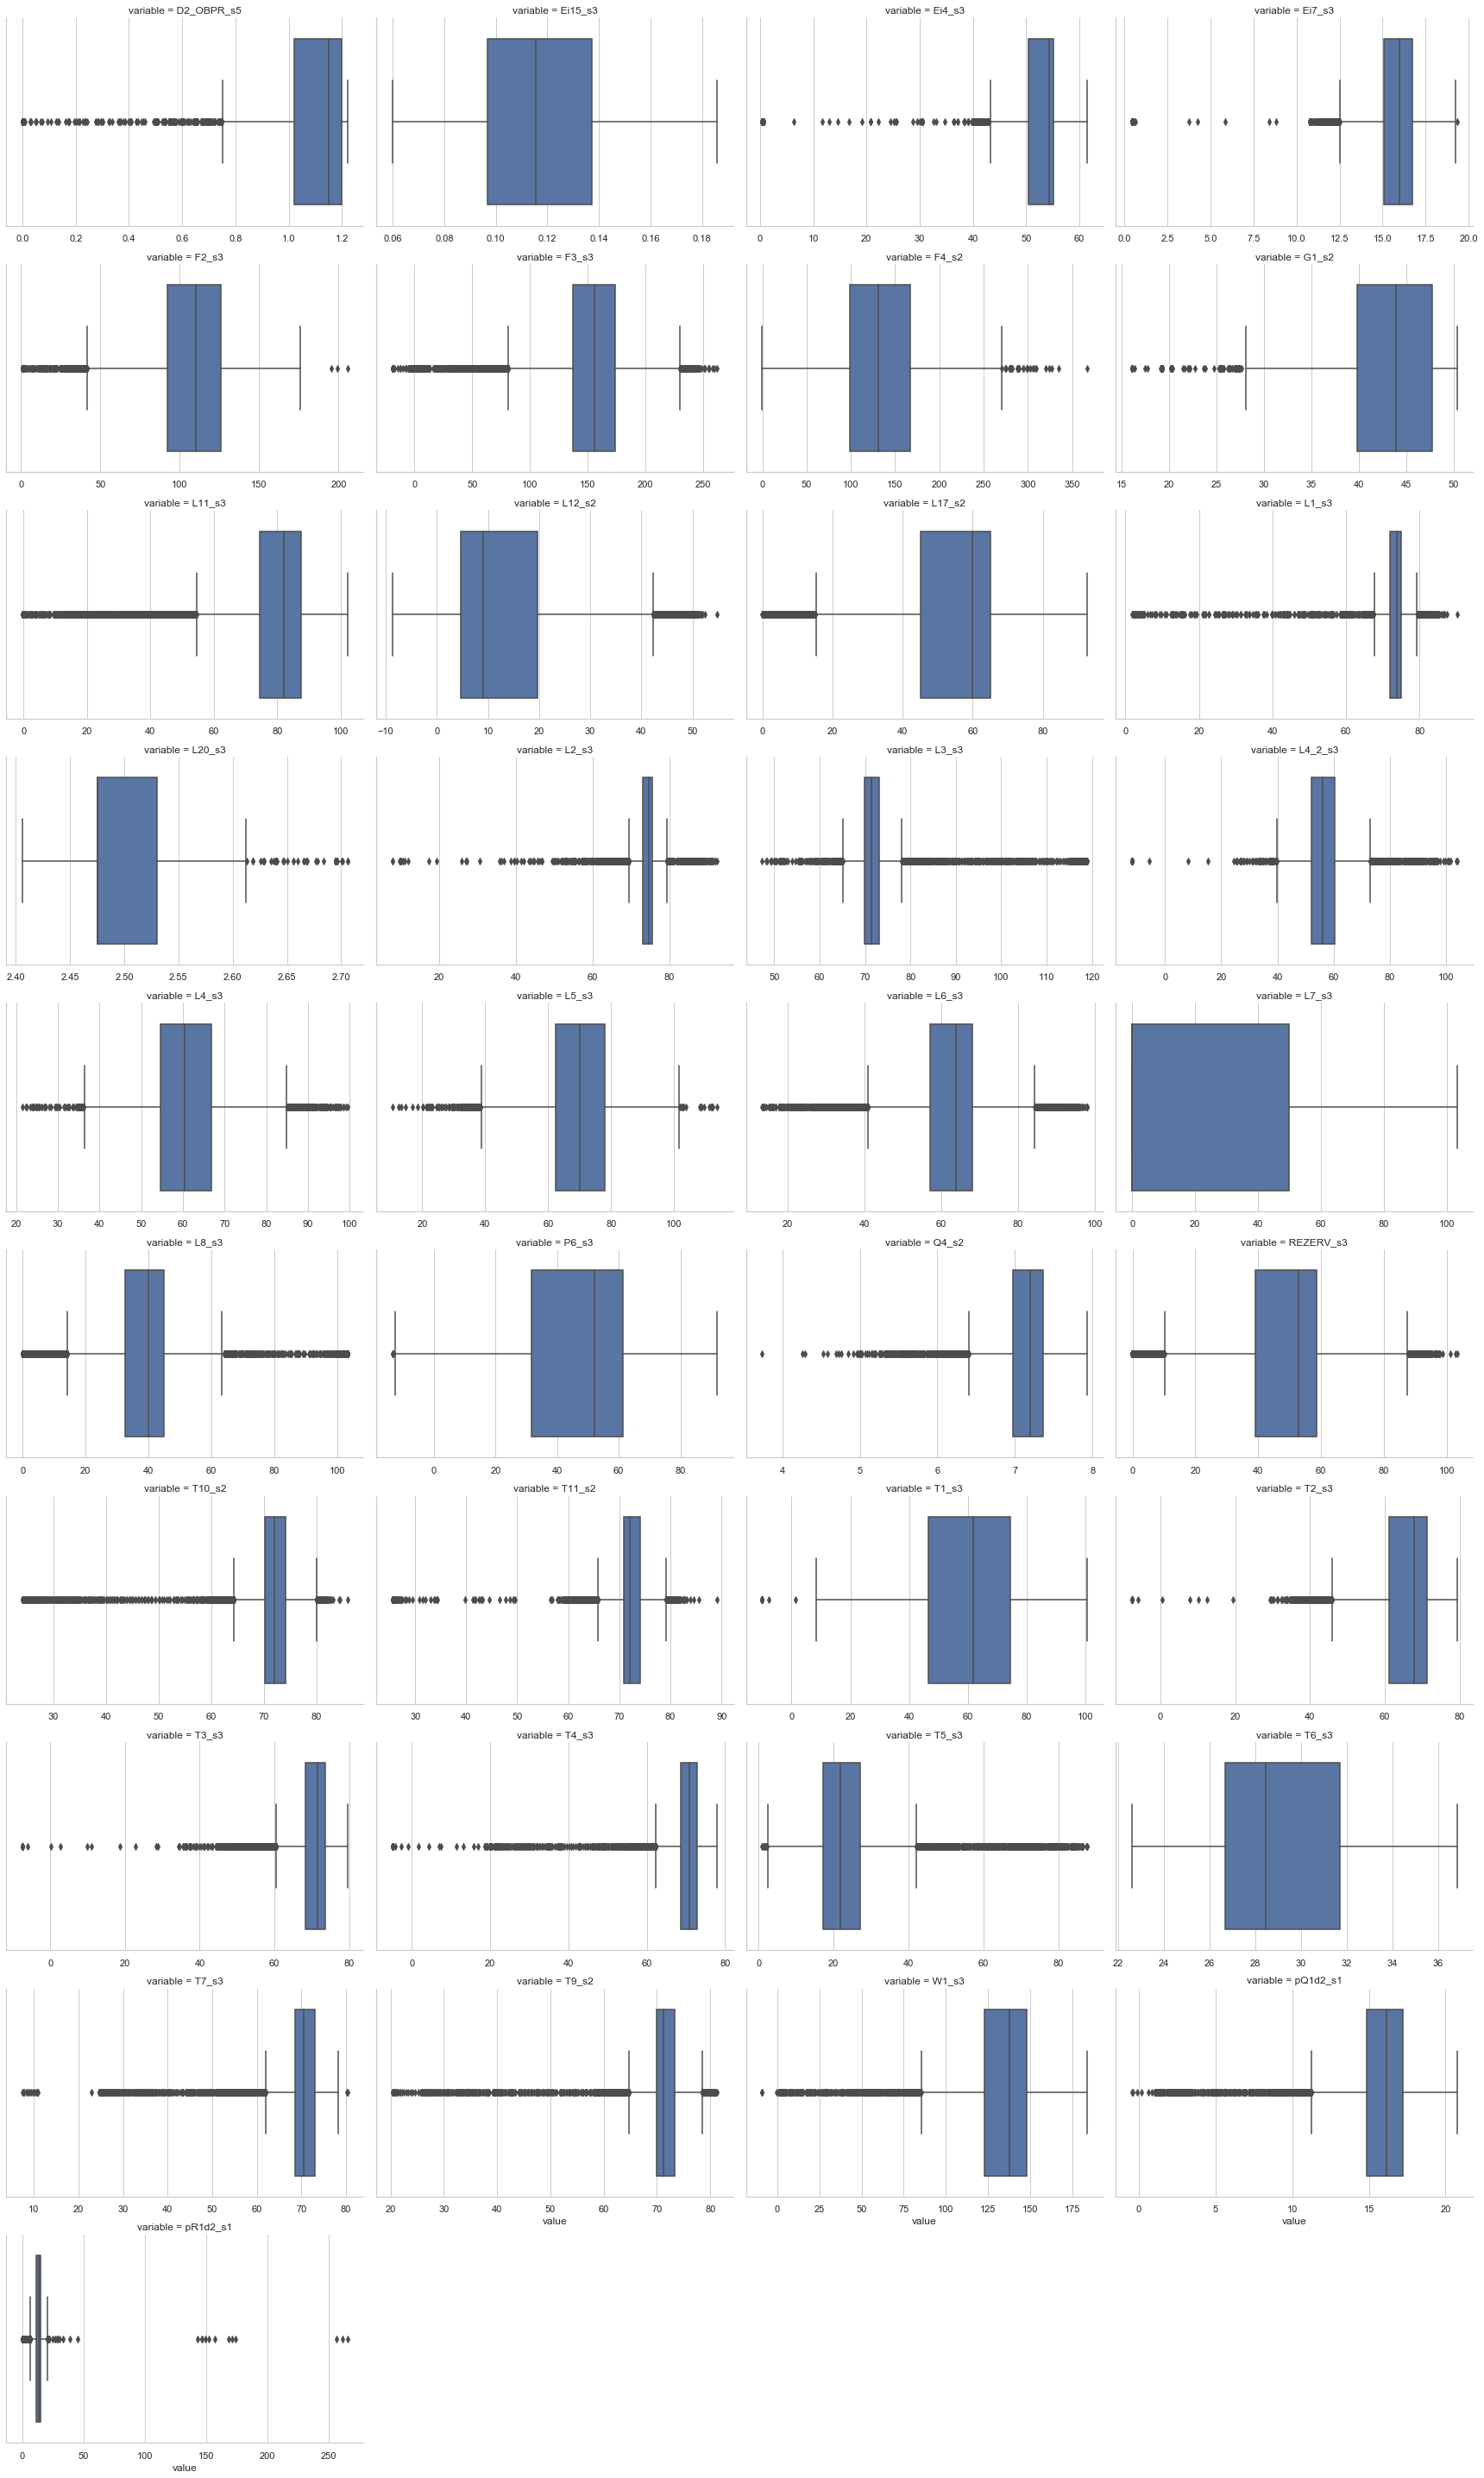

In [22]:
grid = sns.FacetGrid(pd.melt(df), col="variable", sharex=False, sharey=False, col_wrap=4, height=4, aspect=1.5)
grid.map(sns.boxplot, "value")

In [23]:
for feature in df.columns:
    Q1 = df[feature].quantile(0.15)
    Q3 = df[feature].quantile(0.85)
    IQR = Q3 - Q1
    
    df = df.loc[(df[feature] > Q1 - 1.5 * IQR) & (df[feature] < Q3 + 1.5 * IQR)]

In [24]:
df.shape

(7430, 37)

## generate target

In [25]:
df_shifted = df['pR1d2_s1'].copy()
df_shifted.index = df_shifted.index - pd.DateOffset(minutes=30)
df = pd.merge(df, df_shifted, left_index=True, right_index=True)

In [26]:
df.head()

,D2_OBPR_s5,Ei15_s3,Ei4_s3,Ei7_s3,F2_s3,F3_s3,F4_s2,G1_s2,L11_s3,L12_s2,...,T3_s3,T4_s3,T5_s3,T6_s3,T7_s3,T9_s2,W1_s3,pQ1d2_s1,pR1d2_s1_x,pR1d2_s1_y
DT,,,,,,,,,,,,,,,,,,,,,
2019-09-24 22:20:00,0.95,0.13,49.90,17.04,130.65,162.62,110.51,50.13,82.85,26.28,...,75.76,75.10,21.95,32.15,68.97,79.90,165.05,17.73,15.42,12.58
2019-09-24 22:30:00,0.95,0.12,49.88,17.13,136.39,147.49,104.45,50.13,80.51,30.09,...,76.10,75.29,21.08,32.25,69.52,79.60,164.42,17.74,14.14,13.03
2019-09-24 22:40:00,0.95,0.12,49.89,16.88,139.64,130.99,106.46,50.14,78.92,26.89,...,76.31,75.53,19.93,32.40,69.97,79.60,163.54,17.76,12.61,13.72
2019-09-24 22:50:00,0.95,0.12,49.89,16.50,139.99,129.31,112.08,50.14,77.82,24.06,...,76.36,75.82,19.05,32.54,70.44,79.57,163.21,17.88,12.58,14.02
2019-09-24 23:00:00,0.95,0.12,49.91,16.35,139.84,133.80,117.30,50.14,77.70,22.25,...,76.24,76.06,18.89,32.58,70.41,79.22,163.50,18.04,13.03,14.50


In [27]:
df['loss'] = df['pR1d2_s1_y'] / df['W1_s3'] / 2 * 100
df.drop(columns=['pR1d2_s1_x', 'pR1d2_s1_y'], inplace=True)
df = df.round(2)

In [28]:
df.head()

,D2_OBPR_s5,Ei15_s3,Ei4_s3,Ei7_s3,F2_s3,F3_s3,F4_s2,G1_s2,L11_s3,L12_s2,...,T2_s3,T3_s3,T4_s3,T5_s3,T6_s3,T7_s3,T9_s2,W1_s3,pQ1d2_s1,loss
DT,,,,,,,,,,,,,,,,,,,,,
2019-09-24 22:20:00,0.95,0.13,49.90,17.04,130.65,162.62,110.51,50.13,82.85,26.28,...,65.81,75.76,75.10,21.95,32.15,68.97,79.90,165.05,17.73,3.81
2019-09-24 22:30:00,0.95,0.12,49.88,17.13,136.39,147.49,104.45,50.13,80.51,30.09,...,66.26,76.10,75.29,21.08,32.25,69.52,79.60,164.42,17.74,3.96
2019-09-24 22:40:00,0.95,0.12,49.89,16.88,139.64,130.99,106.46,50.14,78.92,26.89,...,66.50,76.31,75.53,19.93,32.40,69.97,79.60,163.54,17.76,4.19
2019-09-24 22:50:00,0.95,0.12,49.89,16.50,139.99,129.31,112.08,50.14,77.82,24.06,...,66.17,76.36,75.82,19.05,32.54,70.44,79.57,163.21,17.88,4.29
2019-09-24 23:00:00,0.95,0.12,49.91,16.35,139.84,133.80,117.30,50.14,77.70,22.25,...,65.40,76.24,76.06,18.89,32.58,70.41,79.22,163.50,18.04,4.43


## train test split

In [29]:
cols = df.columns.tolist()

In [30]:
non_optimized_features = list(set(df.columns.tolist()).difference(set(optimized_features)))

In [31]:
df = df[optimized_features + non_optimized_features]

In [32]:
df

,T1_s3,T2_s3,T3_s3,T4_s3,T7_s3,T10_s2,Q4_s2,L5_s3,Ei15_s3,L20_s3,...,T5_s3,pQ1d2_s1,L3_s3,loss,Ei7_s3,F2_s3,F3_s3,L4_s3,L6_s3,D2_OBPR_s5
DT,,,,,,,,,,,,,,,,,,,,,
2019-09-24 22:20:00,48.62,65.81,75.76,75.10,68.97,80.51,7.07,78.64,0.13,2.48,...,21.95,17.73,77.98,3.81,17.04,130.65,162.62,75.66,75.00,0.95
2019-09-24 22:30:00,48.87,66.26,76.10,75.29,69.52,80.12,7.23,75.91,0.12,2.48,...,21.08,17.74,74.86,3.96,17.13,136.39,147.49,65.92,69.92,0.95
2019-09-24 22:40:00,48.33,66.50,76.31,75.53,69.97,79.08,7.39,73.92,0.12,2.48,...,19.93,17.76,73.30,4.19,16.88,139.64,130.99,64.51,69.76,0.95
2019-09-24 22:50:00,46.87,66.17,76.36,75.82,70.44,78.12,7.46,74.06,0.12,2.48,...,19.05,17.88,73.35,4.29,16.50,139.99,129.31,64.75,70.43,0.95
2019-09-24 23:00:00,45.45,65.40,76.24,76.06,70.41,77.76,7.51,75.31,0.12,2.48,...,18.89,18.04,73.61,4.43,16.35,139.84,133.80,69.40,70.86,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-16 10:50:00,43.10,62.57,67.56,69.94,76.13,71.84,6.88,65.28,0.11,2.53,...,17.22,16.03,70.80,5.53,16.67,108.65,182.18,61.87,62.37,1.20
2019-12-16 11:00:00,44.86,63.29,68.37,70.42,74.84,71.88,6.95,66.54,0.11,2.53,...,18.27,16.06,70.17,4.82,16.82,108.33,174.19,61.63,62.78,1.20
2019-12-16 11:10:00,46.16,63.88,69.14,70.94,73.49,72.12,7.02,67.89,0.11,2.53,...,19.15,16.17,69.91,5.04,16.89,109.02,172.97,61.77,63.09,1.20


In [33]:
X = df.drop(columns=['loss'])
y = df[['loss']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## shuffle train

In [34]:
X_train, y_train = shuffle(X_train, y_train)

## standard scaler

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## NN

In [37]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam()
model.compile(optimizer=optimizer, loss='mae')

history = model.fit(X_train, y_train, epochs=512, batch_size=2024, verbose=0, validation_split=0.1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




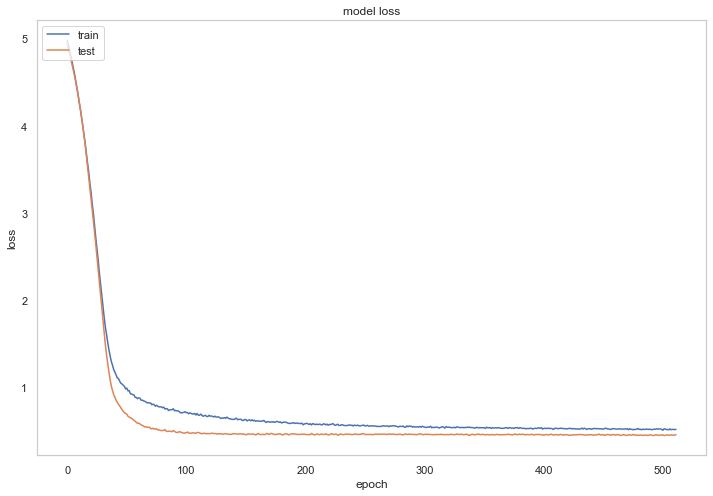

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [39]:
df_test = pd.DataFrame()
df_test['prediction'] = model.predict(X_test)[:,0]
df_test['y'] = y_test.values 
df_test['DT'] = y_test.index
df_test.set_index('DT', inplace=True)

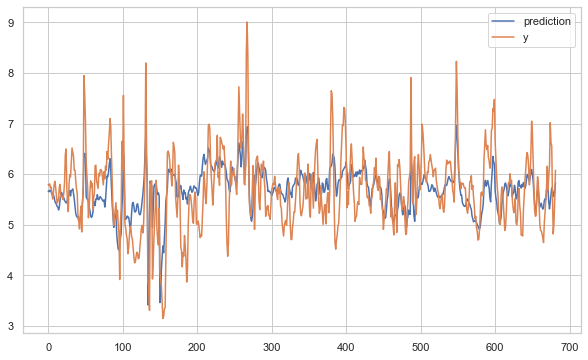

In [40]:
df_test.reset_index(drop=True).plot(figsize=(10, 6), grid=True)

In [41]:
mean_squared_error(df_test['y'], df_test['prediction'])

0.327042953453797

## find optima

In [42]:
df_mean = df.median().to_frame().T
df_mean.drop(columns=['loss'], inplace=True)
df_mean_sc = pd.DataFrame(scaler.transform(df_mean), columns=df_mean.columns)

In [43]:
df_mean

,T1_s3,T2_s3,T3_s3,T4_s3,T7_s3,T10_s2,Q4_s2,L5_s3,Ei15_s3,L20_s3,...,Ei4_s3,T5_s3,pQ1d2_s1,L3_s3,Ei7_s3,F2_s3,F3_s3,L4_s3,L6_s3,D2_OBPR_s5
0,63.82,68.67,71.80,71.05,70.97,72.22,7.22,71.03,0.12,2.48,...,54.53,21.23,16.52,71.26,16.17,114.61,159.59,60.74,64.04,1.17


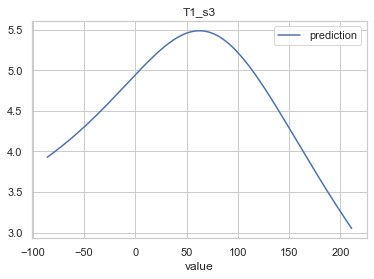

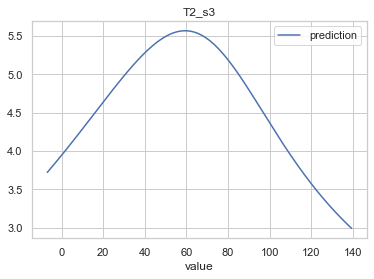

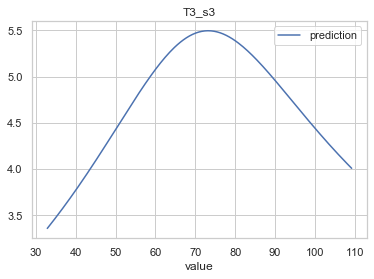

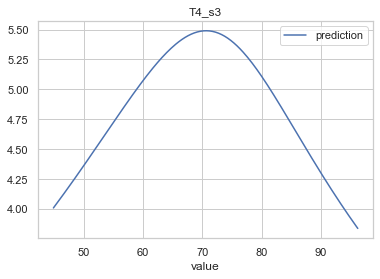

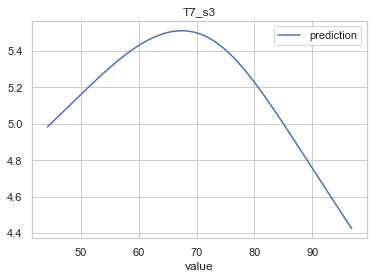

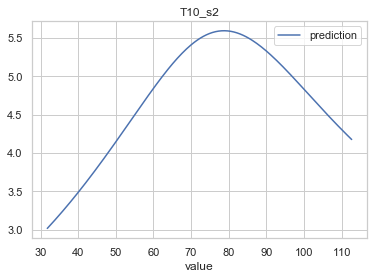

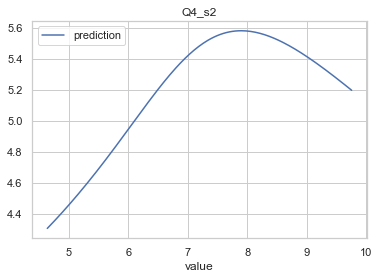

In [44]:
max_values = {}

for param in optimized_features:
    predictions = []
    vals = []

    for new_val in range(-100, 100, 1):
        df_mean_sc_copy = df_mean_sc.copy()
        df_mean_sc_copy[param] = new_val / 10
        
        prediction_sc = model.predict(df_mean_sc_copy)
        prediction = prediction_sc

        predictions.append(prediction[0][0])
        vals.append(pd.DataFrame(scaler.inverse_transform(df_mean_sc_copy), columns=df_mean.columns)[param].values[0])

    plot_df = pd.DataFrame()
    plot_df['prediction'] = predictions
    plot_df['value'] = vals    
    plot_df = plot_df.set_index('value', drop=True)
    
    max_values[param] = round(plot_df.idxmax().values[0], 3)

    plot_df.plot(title=param)
    plt.show()

In [45]:
max_values

{'T1_s3': 61.76,
 'T2_s3': 59.279,
 'T3_s3': 73.153,
 'T4_s3': 70.677,
 'T7_s3': 67.464,
 'T10_s2': 78.949,
 'Q4_s2': 7.903}

## gradient descent

In [46]:
df_sample = df.sample(1, random_state=12)
df_sample.drop(columns='loss', inplace=True)

In [47]:
df_sample

,T1_s3,T2_s3,T3_s3,T4_s3,T7_s3,T10_s2,Q4_s2,L5_s3,Ei15_s3,L20_s3,...,Ei4_s3,T5_s3,pQ1d2_s1,L3_s3,Ei7_s3,F2_s3,F3_s3,L4_s3,L6_s3,D2_OBPR_s5
DT,,,,,,,,,,,,,,,,,,,,,
2019-10-19 19:50:00,70.12,69.07,70.51,68.37,69.53,66.63,7.41,63.32,0.16,2.42,...,54.06,23.67,17.89,71.89,17.92,136.13,155.95,56.39,62.99,0.98


In [48]:
df_gd = df_sample.copy()

for key, value in max_values.items():
    df_gd[key] = value

predictions = []
derivative_step = 0.001

for i in range(0, 10000):
    for col in df_gd[optimized_features]:
        value = df_gd[col].values[0]
        
        min_limit = limits['min'].loc[limits['Object'] == col].values[0]
        max_limit = limits['max'].loc[limits['Object'] == col].values[0]
        
        if value < min_limit:
            df_gd[col] = min_limit
        if value > max_limit:
            df_gd[col] = max_limit

    df_gd_sc = scaler.transform(df_gd)

    prediction = model.predict(df_gd_sc)
    predictions.append(prediction[0][0])

    X_matrix = np.tile(df_gd_sc, (len(optimized_features), 1))
    DELTA_matrix = np.zeros((X_matrix.shape[0], X_matrix.shape[1]), float)
    np.fill_diagonal(DELTA_matrix, derivative_step)
    MODEL_matrix = np.add(X_matrix, DELTA_matrix)

    predictions_new = model.predict(MODEL_matrix)

    DERIVATIVE_matrix = (predictions_new - prediction) / (derivative_step)
    DERIVATIVE_matrix = np.append(DERIVATIVE_matrix, [0] * (len(df_sample.columns) - len(optimized_features)))

    df_gd_sc = pd.DataFrame([np.add(df_gd_sc[0], 0.04 * DERIVATIVE_matrix)])
    df_gd = pd.DataFrame(scaler.inverse_transform(df_gd_sc))
    df_gd.columns = df_sample.columns


df_gd = df_gd.round(3)
y_optimal = (predictions[-1])

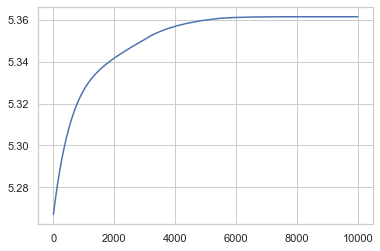

In [49]:
plt.plot(predictions)